In [29]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os, glob, joblib
from torch.utils.data import DataLoader,TensorDataset
from torch.autograd import grad

In [1]:
data_path = "/home/bhagya/Data_Bhagya_internship_wav2vec_xlsr_IIITH_23L/23lang_wav2_vec_features/"
languages = ["Assamese", "Bengali", "Bodo", "Dogri", "English", "Gujarati", "Hindi", "Kannada",
             "Kashmiri", "Konkani", "Maithili", "Malayalam", "Manipuri", "Marathi", "Nepali",
             "Odia", "Punjabi", "Sanskrit", "Santali", "Sindhi", "Tamil", "Telugu", "Urdu"]

# Define indices for Indo-Aryan and Dravidian languages
indo_aryan_indices = [languages.index(lang) for lang in ["Hindi", "Bengali", "Marathi", "Gujarati"]]
dravidian_indices = [languages.index(lang) for lang in ["Tamil", "Telugu", "Kannada", "Malayalam"]]
punjabi_index = languages.index("Punjabi")

# Function to load data for each language
def load_language_data(language):
    X_train_lang = np.load(data_path + f"X_train_original_VAD30_wav2vec2_xlsr_small_last16_cms_{language}.npy")
    y_train_lang = np.load(data_path + f"y_train_original_VAD30_wav2vec2_xlsr_small_last16_cms_{language}.npy")
    X_test_lang = np.load(data_path + f"X_test_original_VAD30_wav2vec2_xlsr_small_last16_cms_{language}.npy")
    y_test_lang = np.load(data_path + f"y_test_original_VAD30_wav2vec2_xlsr_small_last16_cms_{language}.npy")
    return X_train_lang, y_train_lang, X_test_lang, y_test_lang


# Filter and balance data function
def filter_and_balance_data(X, y, indo_aryan_indices, dravidian_indices, punjabi_index, use_bengali_instead_of_punjabi=False):
    indo_aryan_mask = np.isin(y, indo_aryan_indices)
    dravidian_mask = np.isin(y, dravidian_indices)
    punjabi_mask = (y == punjabi_index)

    if use_bengali_instead_of_punjabi:
        bengali_index = languages.index("Bengali")
        indo_aryan_mask = indo_aryan_mask & (~punjabi_mask)
        indo_aryan_mask[bengali_index] = True

    X_indo_aryan = X[indo_aryan_mask]
    y_indo_aryan = y[indo_aryan_mask]

    X_dravidian = X[dravidian_mask]
    y_dravidian = y[dravidian_mask]

    # Create binary labels for training set
    X_train_binary = np.concatenate((X_indo_aryan, X_dravidian), axis=0)
    y_train_binary = np.concatenate((np.zeros(len(X_indo_aryan)), np.ones(len(X_dravidian))), axis=0)

    # Only punjabi data for validation set
    X_valid_punjabi = X[punjabi_mask]
    y_valid_punjabi_binary = np.zeros(len(X_valid_punjabi))

    return X_train_binary, y_train_binary, X_valid_punjabi, y_valid_punjabi_binary

# Load data for all languages
X_train_all, y_train_all, X_test_all, y_test_all = [], [], [], []
for language in languages:
    X_train_lang, y_train_lang, X_test_lang, y_test_lang = load_language_data(language)
    X_train_all.append(X_train_lang)
    y_train_all.append(y_train_lang)
    X_test_all.append(X_test_lang)
    y_test_all.append(y_test_lang)

# Concatenate all languages data
X_train = np.concatenate(X_train_all, axis=0)
y_train = np.concatenate(y_train_all, axis=0)
X_test = np.concatenate(X_test_all, axis=0)
y_test = np.concatenate(y_test_all, axis=0)

# Train with Bengali instead of Punjabi in Indo-Aryan set
X_train_binary, y_train_binary, X_valid_punjabi, y_valid_punjabi_binary = filter_and_balance_data(X_train, y_train,
                                                                                                   indo_aryan_indices,
                                                                                                   dravidian_indices,
                                                                                                   punjabi_index,
                                                                                                   use_bengali_instead_of_punjabi=True)

# Test with only Punjabi in Indo-Aryan set
X_test_punjabi = X_test[y_test == punjabi_index]
y_test_punjabi_binary = np.zeros(len(X_test_punjabi))

# Dravidian set remains the same for testing
X_test_dravidian = X_test[np.isin(y_test, dravidian_indices)]
y_test_dravidian_binary = np.ones(len(X_test_dravidian))

print(f'X_train_binary shape: {X_train_binary.shape}, y_train_binary shape: {y_train_binary.shape}')
print(f'X_valid_punjabi shape: {X_valid_punjabi.shape}, y_valid_punjabi_binary shape: {y_valid_punjabi_binary.shape}')
print(f'X_test_punjabi shape: {X_test_punjabi.shape}, y_test_punjabi_binary shape: {y_test_punjabi_binary.shape}')
print(f'X_test_dravidian shape: {X_test_dravidian.shape}, y_test_dravidian_binary shape: {y_test_dravidian_binary.shape}')



ValueError: 'telugu' is not in list

In [31]:
#ecapa noramal
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchsummary import summary
import math
import sys
sys.path.insert(0, "/home/bhagya/asv-subtools-master/pytorch/")
import libs.support.utils as utils
from libs.nnet import *

# refs:
# 1.  ECAPA-TDNN: Emphasized Channel Attention, Propagation and Aggregation in TDNN Based Speaker Verification
#           https://arxiv.org/abs/2005.07143
# 2.  Unofficial implementation of the ECAPA-TDNN model.
#       https://github.com/lawlict/ECAPA-TDNN




''' Res2Conv1d + BatchNorm1d + ReLU
'''
class Res2Conv1dReluBn(nn.Module):
    '''
    inputs_dim == out_channels == channels
    '''
    def __init__(self, channels, kernel_size=1, stride=1, padding=0, dilation=1, bias=False, scale=4):
        super().__init__()
        assert channels % scale == 0, "{} % {} != 0".format(channels, scale)
        self.scale = scale
        self.width = channels // scale
        self.nums = scale if scale == 1 else scale - 1

        self.convs = []
        self.bns = []
        for i in range(self.nums):
            self.convs.append(nn.Conv1d(self.width, self.width, kernel_size, stride, padding, dilation, bias=bias))
            self.bns.append(nn.BatchNorm1d(self.width))
        self.convs = nn.ModuleList(self.convs)
        self.bns = nn.ModuleList(self.bns)

    def forward(self, x):
        out = []
        spx = torch.split(x, self.width, 1)
        for i in range(self.nums):
            if i == 0:
                sp = spx[i]
            else:
                sp = sp + spx[i]
            # Order: conv -> relu -> bn
            sp = self.convs[i](sp)
            sp = self.bns[i](F.relu(sp))
            out.append(sp)
        if self.scale != 1:
            out.append(spx[self.nums])
        out = torch.cat(out, dim=1)
        return out



''' Conv1d + BatchNorm1d + ReLU
'''
class Conv1dReluBn(nn.Module):
    def __init__(self, inputs_dim, out_channels, kernel_size=1, stride=1, padding=0, dilation=1, bias=False):
        super().__init__()
        self.conv = nn.Conv1d(inputs_dim, out_channels, kernel_size, stride, padding, dilation, bias=bias)
        self.bn = nn.BatchNorm1d(out_channels)

    def forward(self, x):
        return self.bn(F.relu(self.conv(x)))



''' The SE connection of 1D case.
'''
class SE_Connect(nn.Module):
    def __init__(self, channels, s=4):
        super().__init__()
        assert channels % s == 0, "{} % {} != 0".format(channesl, s)
        self.linear1 = nn.Linear(channels, channels // s)
        self.linear2 = nn.Linear(channels // s, channels)

    def forward(self, x):
        out = x.mean(dim=2)
        out = F.relu(self.linear1(out))
        out = torch.sigmoid(self.linear2(out))
        out = x * out.unsqueeze(2)
        return out

#Another implementation of SE_Connect
# class SE_Connect(nn.Module):
#     def __init__(self, channels, bottleneck=128):
#         super(SE_Connect, self).__init__()
#         self.se = nn.Sequential(
#             nn.AdaptiveAvgPool1d(1),
#             nn.Conv1d(channels, bottleneck, kernel_size=1, padding=0),
#             nn.ReLU(),
#             # nn.BatchNorm1d(bottleneck),
#             nn.Conv1d(bottleneck, channels, kernel_size=1, padding=0),
#             nn.Sigmoid(),
#             )

#     def forward(self, input):
#         x = self.se(input)
#         return input * x


''' SE-Res2Block.
    Note: residual connection is implemented in the ECAPA_TDNN model, not here.
'''
def SE_Res2Block(channels, kernel_size, stride, padding, dilation, scale):
    return nn.Sequential(
        Conv1dReluBn(channels, channels, kernel_size=1, stride=1, padding=0),
        Res2Conv1dReluBn(channels, kernel_size, stride, padding, dilation, scale=scale),
        Conv1dReluBn(channels, channels, kernel_size=1, stride=1, padding=0),
        SE_Connect(channels)
    )



''' Attentive weighted mean and standard deviation pooling.
'''
class AttentiveStatsPool(nn.Module):
    def __init__(self, in_dim, bottleneck_dim):
        super().__init__()
        # Use Conv1d with stride == 1 rather than Linear, then we don't need to transpose inputs.
        self.linear1 = nn.Conv1d(in_dim, bottleneck_dim, kernel_size=1) # equals W and b in the paper
        self.linear2 = nn.Conv1d(bottleneck_dim, in_dim, kernel_size=1) # equals V and k in the paper

    def forward(self, x):
        # DON'T use ReLU here! In experiments, I find ReLU hard to converge.
        alpha = torch.tanh(self.linear1(x))
        alpha = torch.softmax(self.linear2(alpha), dim=2)
        mean = torch.sum(alpha * x, dim=2)
        residuals = torch.sum(alpha * x ** 2, dim=2) - mean ** 2
        std = torch.sqrt(residuals.clamp(min=1e-9))
        return torch.cat([mean, std], dim=1)



''' Implementation of
    "ECAPA-TDNN: Emphasized Channel Attention, Propagation and Aggregation in TDNN Based Speaker Verification".

    Note that we DON'T concatenate the last frame-wise layer with non-weighted mean and standard deviation,
    because it brings little improvment but significantly increases model parameters.
    As a result, this implementation basically equals the A.2 of Table 2 in the paper.
'''
class ECAPA_TDNN(TopVirtualNnet):
    def init(self, inputs_dim, num_targets, channels=512, embd_dim=192,
             aug_dropout=0.5, tail_dropout=0.5, training=True,
             extracted_embedding="near", mixup=False, mixup_alpha=1.0,
             pooling="ecpa-attentive", pooling_params={}, fc1=False, fc1_params={}, fc2_params={},
             margin_loss= True, margin_loss_params={}, use_step=False, step_params={}, transfer_from="softmax_loss" ):


        default_pooling_params = {
            "num_head":1,
            "hidden_size":64,
            "share":True,
            "affine_layers":1,
            "context":[0],
            "stddev":True,
            "temperature":False,
            "fixed":True
        }

        default_fc_params = {
            "nonlinearity":'relu', "nonlinearity_params":{"inplace":True},
            "bn-relu":False,
            "bn":True,
            "bn_params":{"momentum":0.5, "affine":True, "track_running_stats":True}
            }


        default_margin_loss_params = {
            "method":"am", "m":0.2,
            "feature_normalize":True, "s":30,
            "double":False,
            "mhe_loss":False, "mhe_w":0.01,
            "inter_loss":0.,
            "ring_loss":0.,
            "curricular":False}

        default_step_params = {
            "T":None,
            "m":False, "lambda_0":0, "lambda_b":1000, "alpha":5, "gamma":1e-4,
            "s":False, "s_tuple":(30, 12), "s_list":None,
            "t":False, "t_tuple":(0.5, 1.2),
            "p":False, "p_tuple":(0.5, 0.1)
        }

        self.use_step = use_step
        self.step_params = step_params
        self.extracted_embedding = extracted_embedding

        pooling_params = utils.assign_params_dict(default_pooling_params, pooling_params)
        fc1_params = utils.assign_params_dict(default_fc_params, fc1_params)
        fc2_params = utils.assign_params_dict(default_fc_params, fc2_params)
        margin_loss_params = utils.assign_params_dict(default_margin_loss_params, margin_loss_params)
        step_params = utils.assign_params_dict(default_step_params, step_params)


        #self.mixup = Mixup(alpha=mixup_alpha) if mixup else None
        #self.pcmvn = AdaptivePCMN(20)
        self.layer1 = Conv1dReluBn(inputs_dim, channels, kernel_size=5, padding=2)
        self.layer2 = SE_Res2Block(channels, kernel_size=3, stride=1, padding=2, dilation=2, scale=8)
        self.layer3 = SE_Res2Block(channels, kernel_size=3, stride=1, padding=3, dilation=3, scale=8)
        self.layer4 = SE_Res2Block(channels, kernel_size=3, stride=1, padding=4, dilation=4, scale=8)
        cat_channels = channels * 3
        self.conv = nn.Conv1d(cat_channels, cat_channels, kernel_size=1)
        self.bn_conv = nn.BatchNorm1d(cat_channels)

        # Pooling
        stddev = pooling_params.pop("stddev")
        if pooling == "attentive":
            self.stats = AttentiveStatisticsPooling(cat_channels, hidden_size=pooling_params["hidden_size"],context=pooling_params["context"], stddev=stddev)
            self.bn_stats = nn.BatchNorm1d(cat_channels * 2)
            self.fc1 = ReluBatchNormTdnnLayer(cat_channels * 2, embd_dim, **fc1_params) if fc1 else None
        elif pooling == "ecpa-attentive":
            self.stats = AttentiveStatsPool(cat_channels,128)
            self.bn_stats = nn.BatchNorm1d(cat_channels * 2)
            self.fc1 = ReluBatchNormTdnnLayer(cat_channels * 2, embd_dim, **fc1_params) if fc1 else None
        elif pooling == "multi-head":
            self.stats = MultiHeadAttentionPooling(cat_channels, stddev=stddev, **pooling_params)
            self.bn_stats = nn.BatchNorm1d(cat_channels * 2)
            self.fc1 = ReluBatchNormTdnnLayer(cat_channels * 2, embd_dim, **fc1_params) if fc1 else None
        elif pooling == "global-multi":
            self.stats = GlobalMultiHeadAttentionPooling(cat_channels,stddev=stddev, **pooling_params)
            self.bn_stats = nn.BatchNorm1d(cat_channels * 2* pooling_params["num_head"])
            self.fc1 = ReluBatchNormTdnnLayer(cat_channels * 2* pooling_params["num_head"], embd_dim, **fc1_params) if fc1 else None
        elif pooling == "multi-resolution":
            self.stats = MultiResolutionMultiHeadAttentionPooling(cat_channels, **pooling_params)
            self.bn_stats = nn.BatchNorm1d(cat_channels * 2* pooling_params["num_head"])
            self.fc1 = ReluBatchNormTdnnLayer(cat_channels * 2* pooling_params["num_head"], embd_dim, **fc1_params) if fc1 else None

        else:
            self.stats = StatisticsPooling(cat_channels, stddev=stddev)
            self.bn_stats = nn.BatchNorm1d(cat_channels * 2)
            self.fc1 = ReluBatchNormTdnnLayer(cat_channels * 2, embd_dim, **fc1_params) if fc1 else None

        self.tail_dropout = torch.nn.Dropout2d(p=tail_dropout) if tail_dropout > 0 else None

        if fc1:
            fc2_in_dim = embd_dim
        else:
            fc2_in_dim = cat_channels * 2
        self.fc2 = ReluBatchNormTdnnLayer(fc2_in_dim, embd_dim, **fc2_params)
        self.tail_dropout = torch.nn.Dropout2d(p=tail_dropout) if tail_dropout > 0 else None

         # Loss
        # Do not need when extracting embedding.
        if training :
            if margin_loss:
                self.loss = MarginSoftmaxLoss(embd_dim, num_targets, **margin_loss_params)
            else:
                self.loss = SoftmaxLoss(embd_dim, num_targets)
                # self.loss = AngleLoss(embd_dim,num_targets)
            self.wrapper_loss = MixupLoss(self.loss, self.mixup) if mixup else None
            # An example to using transform-learning without initializing loss.affine parameters
            self.transform_keys = ["layer2","layer3","layer4","conv","stats","fc1","fc2"]

            if margin_loss and transfer_from == "softmax_loss":
                # For softmax_loss to am_softmax_loss
                self.rename_transform_keys = {"loss.affine.weight":"loss.weight"}

    @utils.for_device_free
    def forward(self, x):
        #x = self.mixup(x)
        #x = self.pcmvn(x)
        out1 = self.layer1(x)
        out2 = self.layer2(out1) + out1
        out3 = self.layer3(out1 + out2) + out1 + out2
        out4 = self.layer4(out1 + out2 + out3) + out1 + out2 + out3
        out = torch.cat([out2, out3, out4], dim=1)
        out = self.bn_conv(F.relu(self.conv(out)))
        x = self.bn_stats(self.stats(out))
        if len(x.shape) !=3:
            x = x.unsqueeze(dim=2)
        x = self.auto(self.fc1, x)
        x = self.fc2(x)
        x = self.auto(self.tail_dropout, x)
        return x

    @utils.for_device_free
    def get_loss(self, inputs, targets):
        """Should call get_loss() after forward() with using Xvector model function.
        e.g.:
            m=Xvector(20,10)
            loss=m.get_loss(m(inputs),targets)

        model.get_loss [custom] -> loss.forward [custom]
          |
          v
        model.get_accuracy [custom] -> loss.get_accuracy [custom] -> loss.compute_accuracy [static] -> loss.predict [static]
        """
        if self.wrapper_loss is not None:
            return self.wrapper_loss(inputs, targets)
        else:
            return self.loss(inputs, targets)

    @utils.for_device_free
    def get_accuracy(self, targets):
        """Should call get_accuracy() after get_loss().
        @return: return accuracy
        """
        if self.wrapper_loss is not None:
            return self.wrapper_loss.get_accuracy(targets)
        else:
            return self.loss.get_accuracy(targets)

    @for_extract_embedding(maxChunk=10000, isMatrix=True)
    def extract_embedding(self, inputs):
        out1 = self.layer1(inputs)
        out2 = self.layer2(out1) + out1
        out3 = self.layer3(out1 + out2) + out1 + out2
        out4 = self.layer4(out1 + out2 + out3) + out1 + out2 + out3
        out = torch.cat([out2, out3, out4], dim=1)
        out = self.bn_conv(F.relu(self.conv(out)))
        x = self.bn_stats(self.stats(out))
        if len(x.shape) !=3:
            x = x.unsqueeze(dim=2)
        if self.extracted_embedding == "far":
            assert self.fc1 is not None
            xvector = self.fc1.affine(x)
        elif self.extracted_embedding == "near_affine":
            x = self.auto(self.fc1, x)
            xvector = self.fc2.affine(x)
        elif self.extracted_embedding == "near":
            x = self.auto(self.fc1, x)
            xvector = self.fc2(x)
        else:
            raise TypeError("Expected far or near position, but got {}".format(self.extracted_embedding))
        return xvector

    def get_warmR_T(T_0, T_mult, epoch):
        n = int(math.log(max(0.05, (epoch / T_0 * (T_mult - 1) + 1)), T_mult))
        T_cur = epoch - T_0 * (T_mult ** n - 1) / (T_mult - 1)
        T_i = T_0 * T_mult ** (n)
        return T_cur, T_i

    def compute_decay_value(self, start, end, T_cur, T_i):
        # Linear decay in every cycle time.
        return start - (start - end)/(T_i-1) * (T_cur%T_i)

    def step(self, epoch, this_iter, epoch_batchs):
        # Heated up for t and s.
        # Decay for margin and dropout p.
        if self.use_step:
            if self.step_params["m"]:
                current_postion = epoch*epoch_batchs + this_iter
                lambda_factor = max(self.step_params["lambda_0"],
                                 self.step_params["lambda_b"]*(1+self.step_params["gamma"]*current_postion)**(-self.step_params["alpha"]))
                self.loss.step(lambda_factor)

            if self.step_params["T"] is not None and (self.step_params["t"] or self.step_params["p"]):
                T_cur, T_i = get_warmR_T(*self.step_params["T"], epoch)
                T_cur = T_cur*epoch_batchs + this_iter
                T_i = T_i * epoch_batchs

            if self.step_params["t"]:
                self.loss.t = self.compute_decay_value(*self.step_params["t_tuple"], T_cur, T_i)

            if self.step_params["p"]:
                self.aug_dropout.p = self.compute_decay_value(*self.step_params["p_tuple"], T_cur, T_i)

            if self.step_params["s"]:
                self.loss.s = self.step_params["s_tuple"][self.step_params["s_list"][epoch]]


if __name__ == '__main__':
    # Input size: batch_size * seq_len * feat_dim
    x = torch.zeros(2, 20, 300)
    model = ECAPA_TDNN(inputs_dim=20,num_targets=5, channels=512, embd_dim=192)
    out = model(x)
    print(model)
    print(out.shape)    # should be [2, 192]

ECAPA_TDNN(
  (layer1): Conv1dReluBn(
    (conv): Conv1d(20, 512, kernel_size=(5,), stride=(1,), padding=(2,), bias=False)
    (bn): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (layer2): Sequential(
    (0): Conv1dReluBn(
      (conv): Conv1d(512, 512, kernel_size=(1,), stride=(1,), bias=False)
      (bn): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): Res2Conv1dReluBn(
      (convs): ModuleList(
        (0-6): 7 x Conv1d(64, 64, kernel_size=(3,), stride=(1,), padding=(2,), dilation=(2,), bias=False)
      )
      (bns): ModuleList(
        (0-6): 7 x BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (2): Conv1dReluBn(
      (conv): Conv1d(512, 512, kernel_size=(1,), stride=(1,), bias=False)
      (bn): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (3): SE_Connect(
      (linear1): Linear(in_features=512

In [32]:
def xv_data_manage(X):
    X_transposed = X.transpose((0, 2, 1))
    print(X.shape, '-->', X_transposed.shape)
    return X_transposed


In [33]:
X_train_binary = xv_data_manage(X_train_binary)
X_valid_punjabi = xv_data_manage(X_valid_punjabi)

# Convert to PyTorch tensors
X_train_tensor = torch.tensor(X_train_binary, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train_binary, dtype=torch.long)
X_valid_tensor = torch.tensor(X_valid_punjabi, dtype=torch.float32)
y_valid_tensor = torch.tensor(y_valid_punjabi_binary, dtype=torch.long)

(7981, 300, 1024) --> (7981, 1024, 300)
(1277, 300, 1024) --> (1277, 1024, 300)


In [34]:
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
model = ECAPA_TDNN(1024, 2).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=2, threshold=0.0001, threshold_mode='rel', cooldown=0, min_lr=1e-8, eps=1e-08, verbose=True)


In [35]:
trainloader = DataLoader(TensorDataset(X_train_tensor, y_train_tensor), shuffle=True, batch_size=256, drop_last=False)
testloader1 = DataLoader(TensorDataset(X_valid_tensor, y_valid_tensor), shuffle=True, batch_size=64, drop_last=False)
print(len(trainloader))
print(len(testloader1))

32
20


In [36]:
np.unique(y_test,return_counts =True)

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22], dtype=int16),
 array([382, 235, 255, 493, 295, 136,  38, 325, 377, 442, 126, 359, 380,
        188, 428, 414, 375, 213, 267,  65, 425, 476, 124]))

Epoch: 0, Batch: 0, Loss: 6.387428283691406, Accuracy: 42.96875%
Total training loss 0.7645004775840789 and training Accuracy 94.38666833730109% after 0 epochs
#####TEST--in-domain:::::Epoch: 0, Batch: 0, Loss: 5.183063983917236, Accuracy:67.1875%


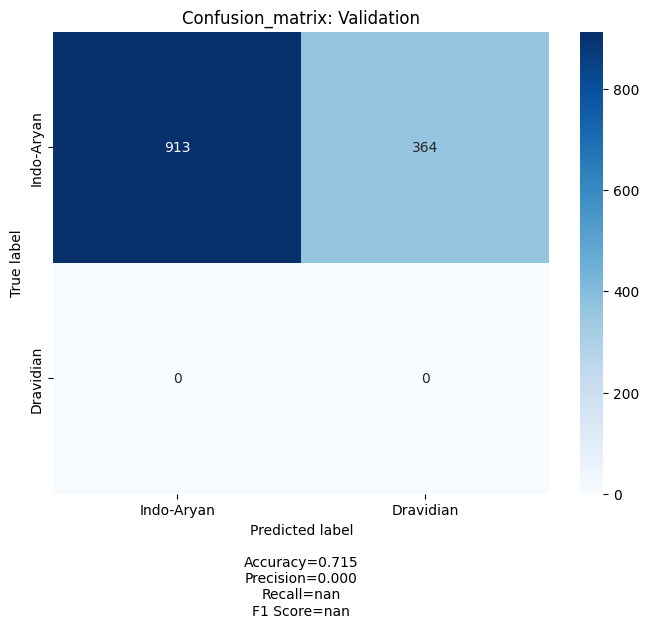

:::::Total validation loss 4.228767597675324, Training accuracy 94.38666833730109%, Validation accuracy 71.49569303054034% after 0 epochs
Epoch: 1, Batch: 0, Loss: 0.24928438663482666, Accuracy: 98.828125%
Total training loss 0.1076243785682891 and training Accuracy 99.3484525748653% after 1 epochs
#####TEST--in-domain:::::Epoch: 1, Batch: 0, Loss: 6.82261323928833, Accuracy:51.5625%


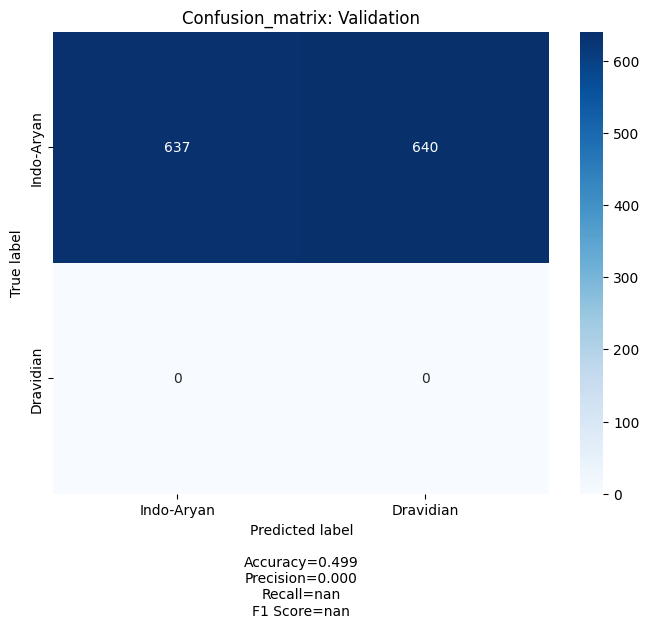

:::::Total validation loss 7.497114944458008, Training accuracy 99.3484525748653%, Validation accuracy 49.88253719655442% after 1 epochs
Epoch: 2, Batch: 0, Loss: 0.020217126235365868, Accuracy: 100.0%
Total training loss 0.0501163818544228 and training Accuracy 99.68675604560832% after 2 epochs
#####TEST--in-domain:::::Epoch: 2, Batch: 0, Loss: 8.964560508728027, Accuracy:53.125%


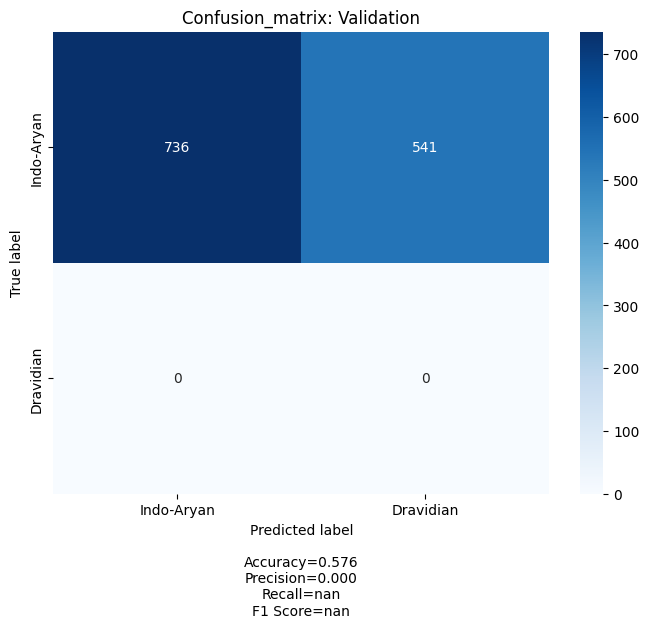

:::::Total validation loss 6.7716479182243345, Training accuracy 99.68675604560832%, Validation accuracy 57.63508222396241% after 2 epochs
Epoch: 3, Batch: 0, Loss: 0.13604822754859924, Accuracy: 99.609375%
Total training loss 0.0548343978016419 and training Accuracy 99.67422628743266% after 3 epochs
#####TEST--in-domain:::::Epoch: 3, Batch: 0, Loss: 7.692543029785156, Accuracy:60.9375%


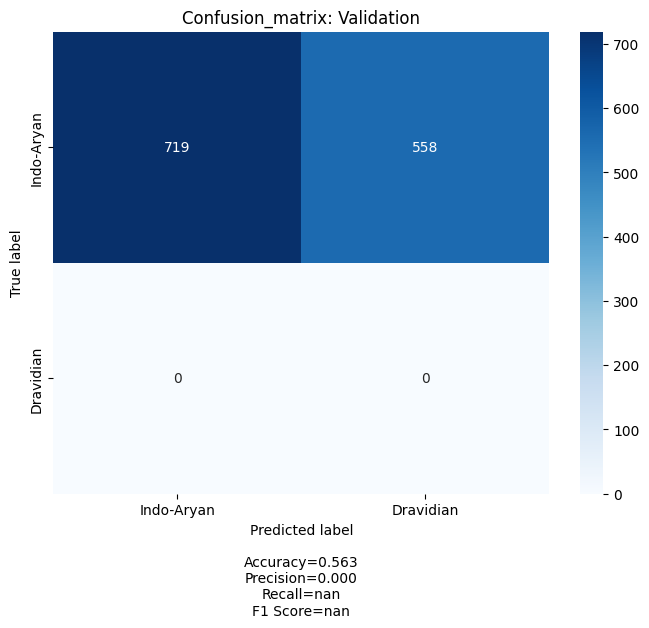

:::::Total validation loss 7.107883477210999, Training accuracy 99.67422628743266%, Validation accuracy 56.303837118245895% after 3 epochs
Epoch: 4, Batch: 0, Loss: 0.12601295113563538, Accuracy: 98.4375%
Total training loss 0.02267084491620608 and training Accuracy 99.86217266006766% after 4 epochs
#####TEST--in-domain:::::Epoch: 4, Batch: 0, Loss: 6.825100421905518, Accuracy:57.8125%


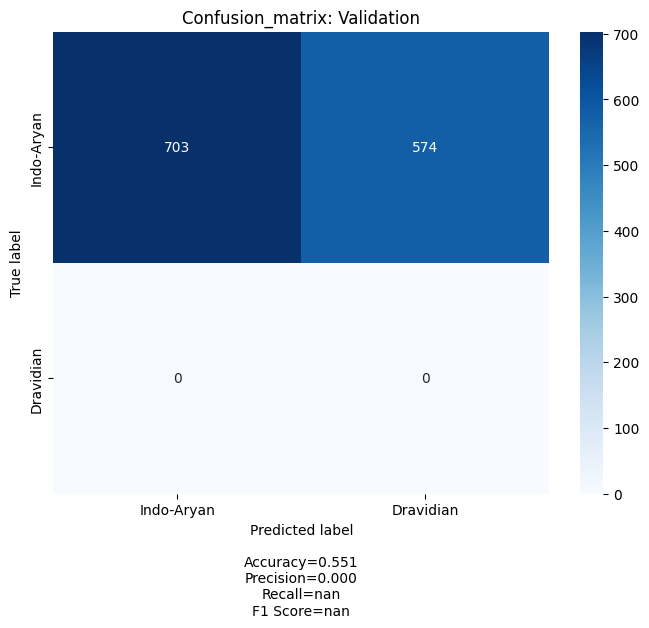

:::::Total validation loss 7.460177612304688, Training accuracy 99.86217266006766%, Validation accuracy 55.05090054815975% after 4 epochs
Epoch: 5, Batch: 0, Loss: 0.01393717247992754, Accuracy: 100.0%
Total training loss 0.005135260750890325 and training Accuracy 99.97494048364867% after 5 epochs
#####TEST--in-domain:::::Epoch: 5, Batch: 0, Loss: 4.962978363037109, Accuracy:68.75%


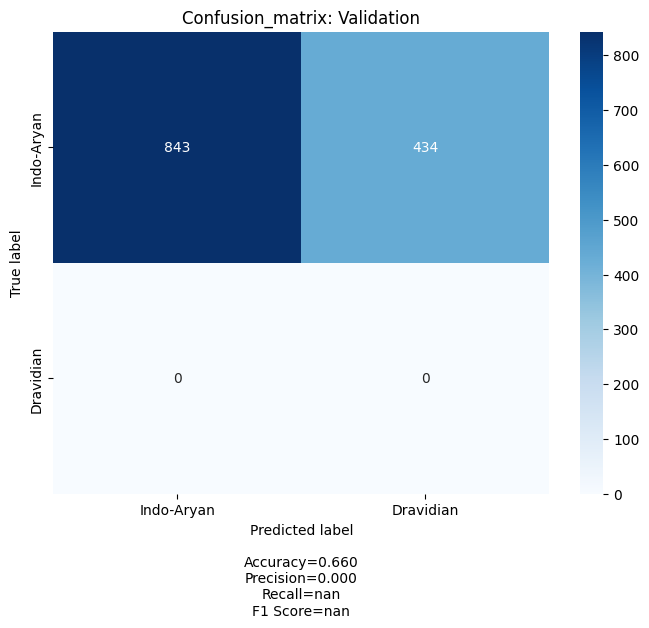

:::::Total validation loss 5.104847860336304, Training accuracy 99.97494048364867%, Validation accuracy 66.01409553641346% after 5 epochs
Epoch: 6, Batch: 0, Loss: 0.005254112649708986, Accuracy: 100.0%
Total training loss 0.003417840578663345 and training Accuracy 99.98747024182433% after 6 epochs
#####TEST--in-domain:::::Epoch: 6, Batch: 0, Loss: 5.963284969329834, Accuracy:57.8125%


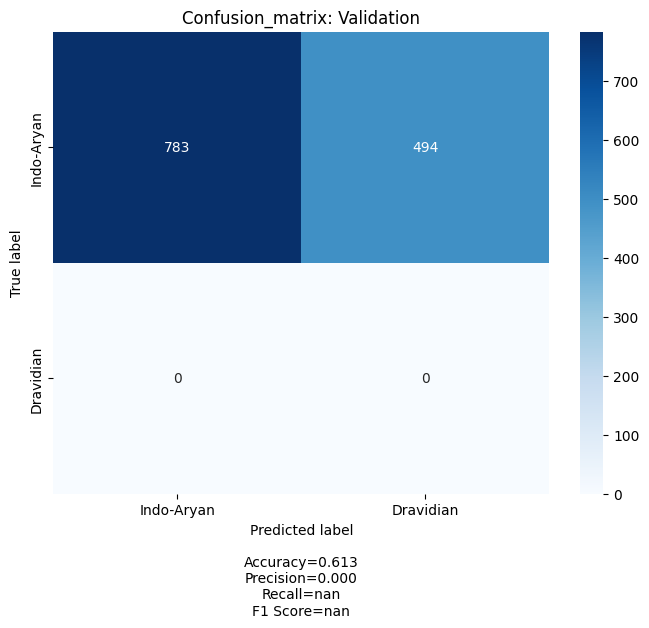

:::::Total validation loss 5.91080253124237, Training accuracy 99.98747024182433%, Validation accuracy 61.31558339859045% after 6 epochs
Epoch: 7, Batch: 0, Loss: 1.48495255416492e-05, Accuracy: 100.0%
Total training loss 0.0023246312498912403 and training Accuracy 99.98747024182433% after 7 epochs
#####TEST--in-domain:::::Epoch: 7, Batch: 0, Loss: 4.441687107086182, Accuracy:64.0625%


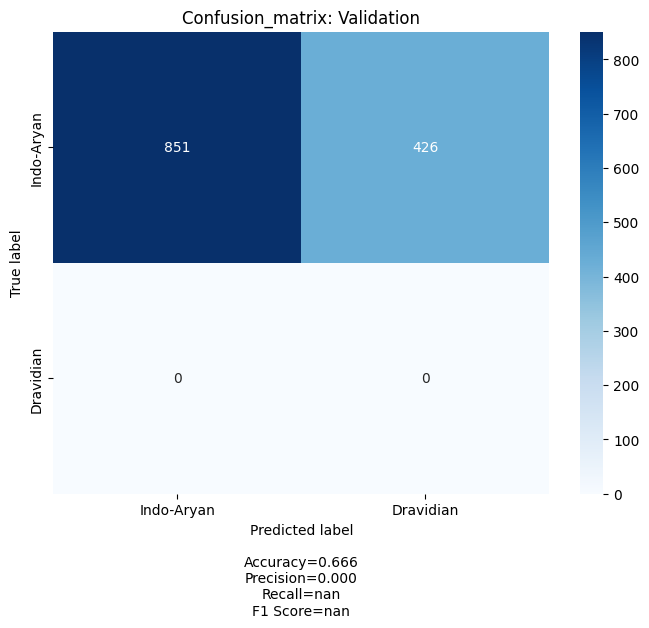

:::::Total validation loss 4.659764432907105, Training accuracy 99.98747024182433%, Validation accuracy 66.64056382145654% after 7 epochs
Epoch: 8, Batch: 0, Loss: 2.0827119442401454e-05, Accuracy: 100.0%
Total training loss 0.0022506302843225967 and training Accuracy 99.98747024182433% after 8 epochs
#####TEST--in-domain:::::Epoch: 8, Batch: 0, Loss: 4.238422870635986, Accuracy:62.5%


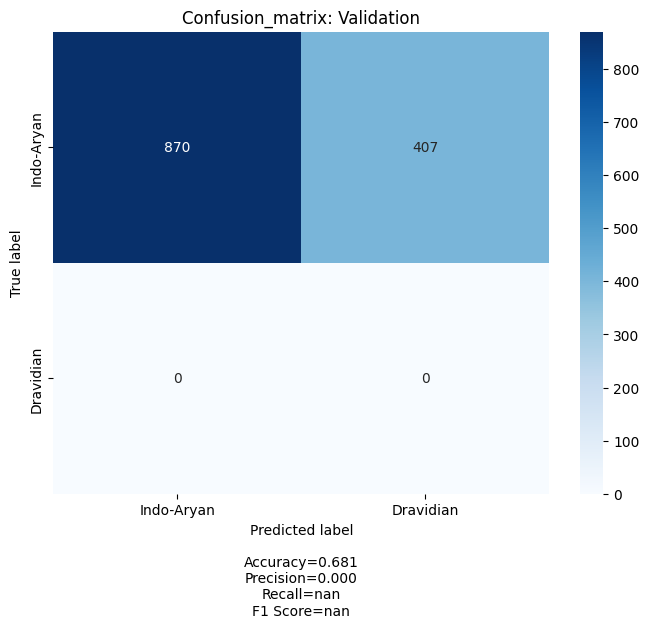

:::::Total validation loss 4.634252762794494, Training accuracy 99.98747024182433%, Validation accuracy 68.12842599843383% after 8 epochs
Epoch: 9, Batch: 0, Loss: 0.00010208543244516477, Accuracy: 100.0%
Total training loss 0.004675773678187056 and training Accuracy 100.0% after 9 epochs
#####TEST--in-domain:::::Epoch: 9, Batch: 0, Loss: 6.9874796867370605, Accuracy:60.9375%


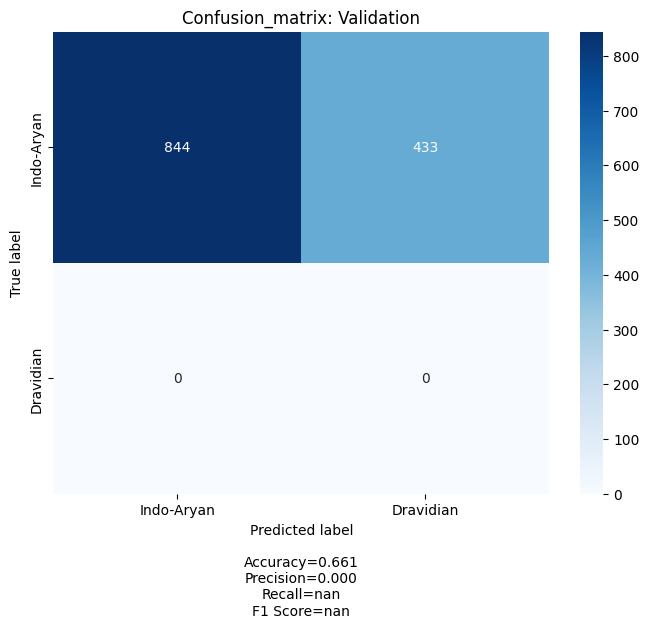

:::::Total validation loss 5.162222123146057, Training accuracy 100.0%, Validation accuracy 66.09240407204385% after 9 epochs
Epoch: 10, Batch: 0, Loss: 3.34886885866581e-06, Accuracy: 100.0%
Total training loss 0.008651032693855143 and training Accuracy 99.94988096729733% after 10 epochs
#####TEST--in-domain:::::Epoch: 10, Batch: 0, Loss: 2.846935272216797, Accuracy:78.125%


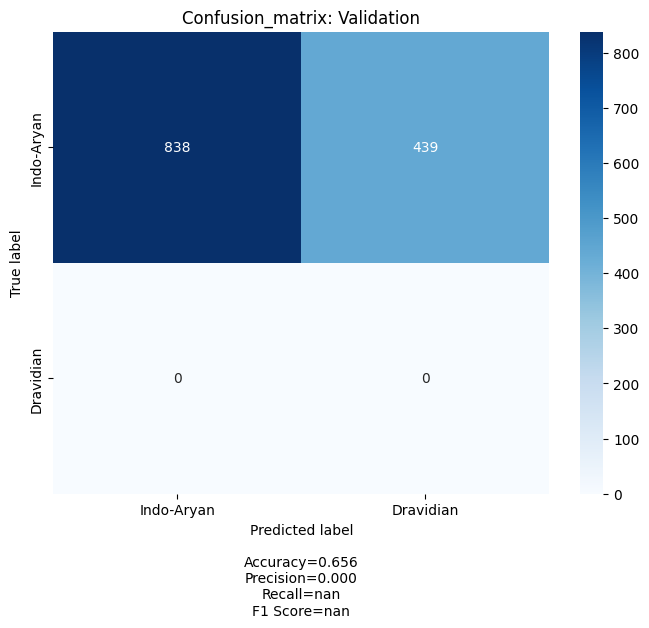

:::::Total validation loss 4.840074384212494, Training accuracy 99.94988096729733%, Validation accuracy 65.62255285826156% after 10 epochs
Epoch: 11, Batch: 0, Loss: 0.033267825841903687, Accuracy: 99.609375%
Total training loss 0.0033030614134119674 and training Accuracy 99.97494048364867% after 11 epochs
#####TEST--in-domain:::::Epoch: 11, Batch: 0, Loss: 7.267299652099609, Accuracy:50.0%


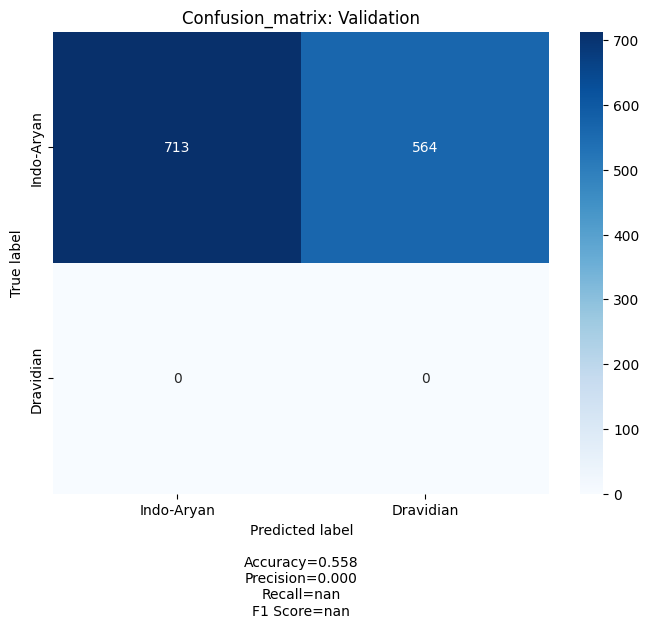

:::::Total validation loss 6.965320134162903, Training accuracy 99.97494048364867%, Validation accuracy 55.83398590446359% after 11 epochs
Epoch: 12, Batch: 0, Loss: 4.928556882077828e-05, Accuracy: 100.0%
Total training loss 0.0016335556348394675 and training Accuracy 100.0% after 12 epochs
#####TEST--in-domain:::::Epoch: 12, Batch: 0, Loss: 6.08830451965332, Accuracy:59.375%


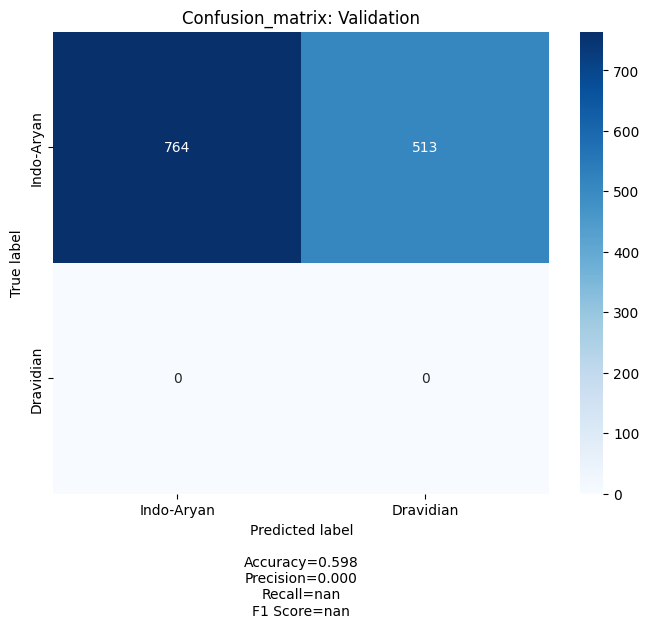

:::::Total validation loss 6.275967073440552, Training accuracy 100.0%, Validation accuracy 59.82772122161315% after 12 epochs
Epoch: 13, Batch: 0, Loss: 2.9211785658844747e-05, Accuracy: 100.0%
Total training loss 0.0004018763191417918 and training Accuracy 100.0% after 13 epochs
#####TEST--in-domain:::::Epoch: 13, Batch: 0, Loss: 4.640998840332031, Accuracy:65.625%


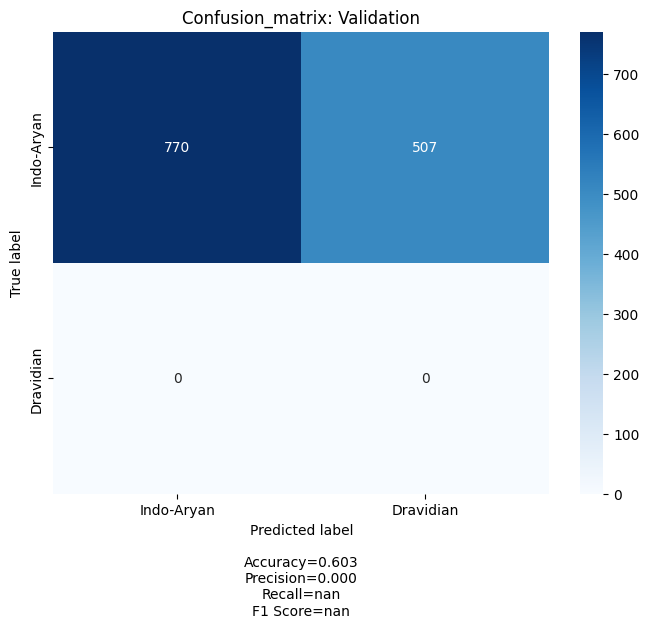

:::::Total validation loss 6.314649975299835, Training accuracy 100.0%, Validation accuracy 60.297572435395466% after 13 epochs
Epoch: 14, Batch: 0, Loss: 1.582907498232089e-05, Accuracy: 100.0%
Total training loss 8.916264115299555e-05 and training Accuracy 100.0% after 14 epochs
#####TEST--in-domain:::::Epoch: 14, Batch: 0, Loss: 5.981851100921631, Accuracy:68.75%


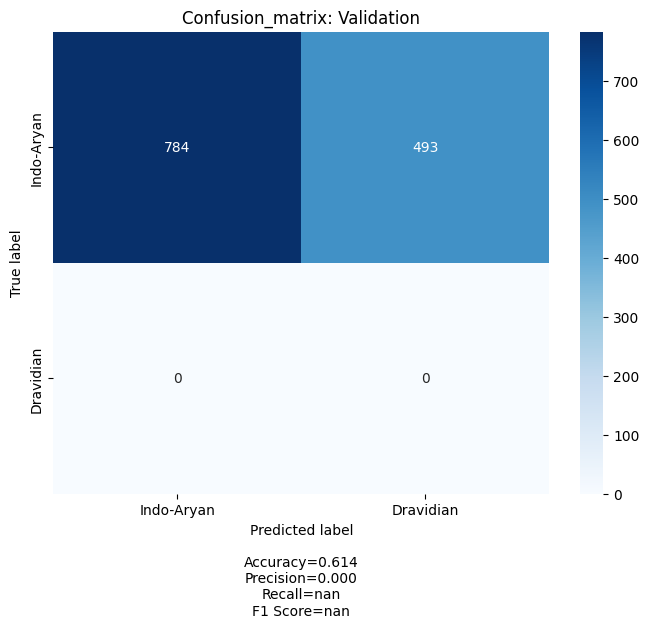

:::::Total validation loss 6.015092968940735, Training accuracy 100.0%, Validation accuracy 61.39389193422083% after 14 epochs
Epoch: 15, Batch: 0, Loss: 3.927861143893097e-06, Accuracy: 100.0%
Total training loss 5.8228085023870335e-05 and training Accuracy 100.0% after 15 epochs
#####TEST--in-domain:::::Epoch: 15, Batch: 0, Loss: 7.585728645324707, Accuracy:50.0%


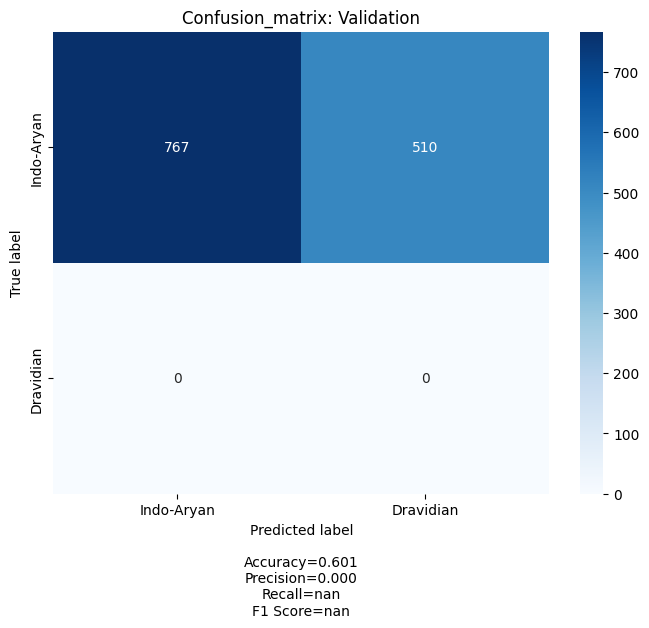

:::::Total validation loss 6.549958634376526, Training accuracy 100.0%, Validation accuracy 60.062646828504306% after 15 epochs
Epoch: 16, Batch: 0, Loss: 7.639842806383967e-05, Accuracy: 100.0%
Total training loss 0.00021796414834085454 and training Accuracy 100.0% after 16 epochs
#####TEST--in-domain:::::Epoch: 16, Batch: 0, Loss: 6.448709487915039, Accuracy:60.9375%


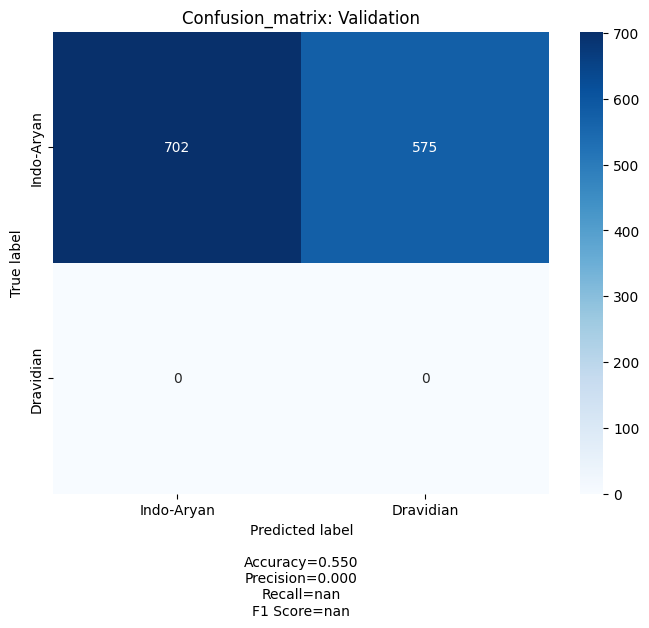

:::::Total validation loss 7.818870544433594, Training accuracy 100.0%, Validation accuracy 54.97259201252936% after 16 epochs
Epoch: 17, Batch: 0, Loss: 4.505846663960256e-05, Accuracy: 100.0%
Total training loss 0.0038068836305384934 and training Accuracy 100.0% after 17 epochs
#####TEST--in-domain:::::Epoch: 17, Batch: 0, Loss: 9.118183135986328, Accuracy:48.4375%


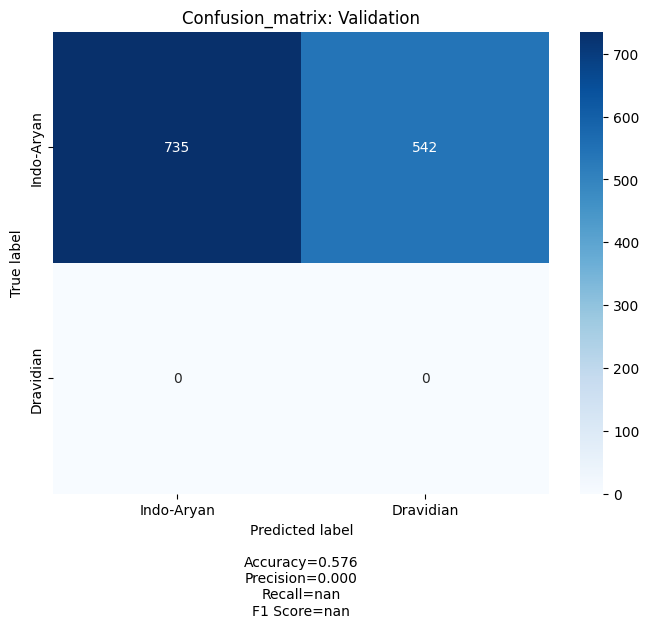

:::::Total validation loss 7.478943705558777, Training accuracy 100.0%, Validation accuracy 57.55677368833203% after 17 epochs
Epoch: 18, Batch: 0, Loss: 9.983958989323583e-06, Accuracy: 100.0%
Total training loss 0.00018258151597905226 and training Accuracy 100.0% after 18 epochs
#####TEST--in-domain:::::Epoch: 18, Batch: 0, Loss: 5.0158586502075195, Accuracy:62.5%


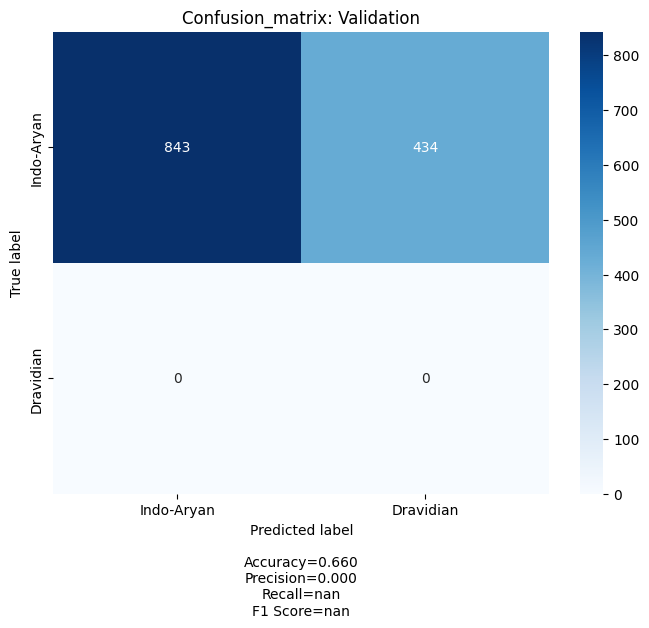

:::::Total validation loss 4.995872938632965, Training accuracy 100.0%, Validation accuracy 66.01409553641346% after 18 epochs
Epoch: 19, Batch: 0, Loss: 7.658615686523262e-06, Accuracy: 100.0%
Total training loss 0.0015306987151220142 and training Accuracy 100.0% after 19 epochs
#####TEST--in-domain:::::Epoch: 19, Batch: 0, Loss: 4.665462493896484, Accuracy:68.75%


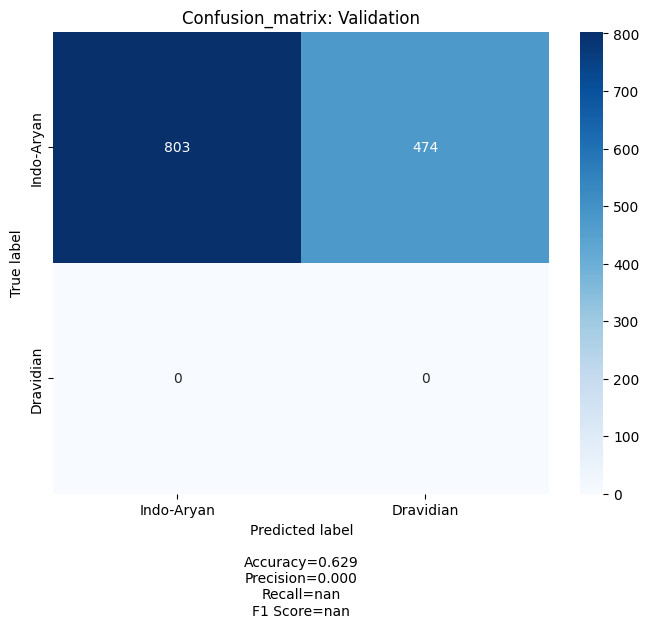

:::::Total validation loss 5.704190945625305, Training accuracy 100.0%, Validation accuracy 62.88175411119812% after 19 epochs
Epoch: 20, Batch: 0, Loss: 1.9467292077024467e-05, Accuracy: 100.0%
Total training loss 0.0001712030228837591 and training Accuracy 100.0% after 20 epochs
#####TEST--in-domain:::::Epoch: 20, Batch: 0, Loss: 7.7443623542785645, Accuracy:54.6875%


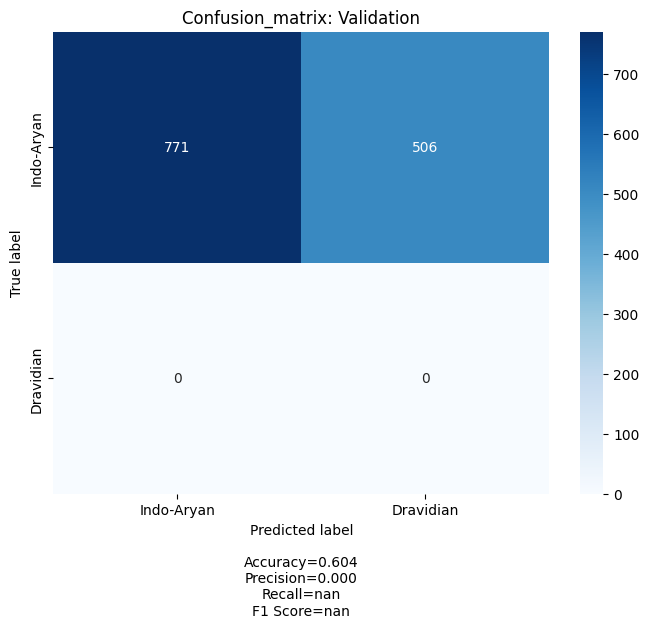

:::::Total validation loss 6.264512014389038, Training accuracy 100.0%, Validation accuracy 60.37588097102584% after 20 epochs
Epoch: 21, Batch: 0, Loss: 2.9800846732541686e-06, Accuracy: 100.0%
Total training loss 0.00026713730033023353 and training Accuracy 100.0% after 21 epochs
#####TEST--in-domain:::::Epoch: 21, Batch: 0, Loss: 6.483862400054932, Accuracy:56.25%


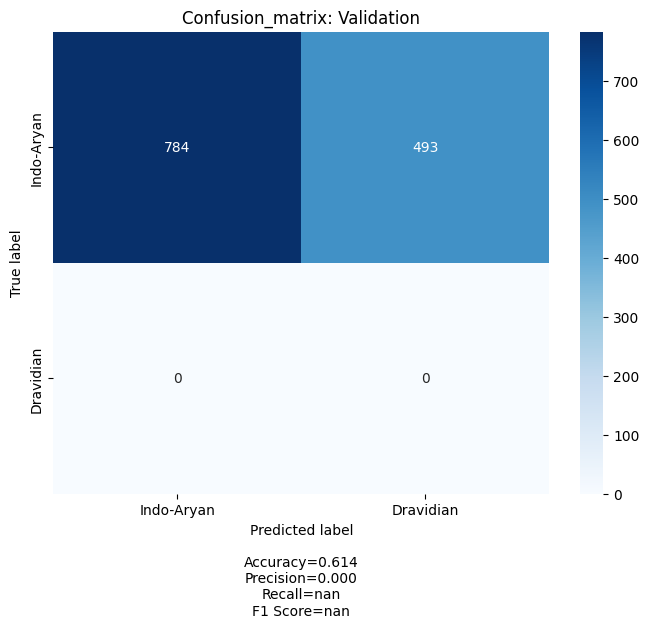

:::::Total validation loss 6.171928811073303, Training accuracy 100.0%, Validation accuracy 61.39389193422083% after 21 epochs
Epoch: 22, Batch: 0, Loss: 1.7238160125998547e-06, Accuracy: 100.0%
Total training loss 0.00037395387922956047 and training Accuracy 100.0% after 22 epochs
#####TEST--in-domain:::::Epoch: 22, Batch: 0, Loss: 7.726037502288818, Accuracy:59.375%


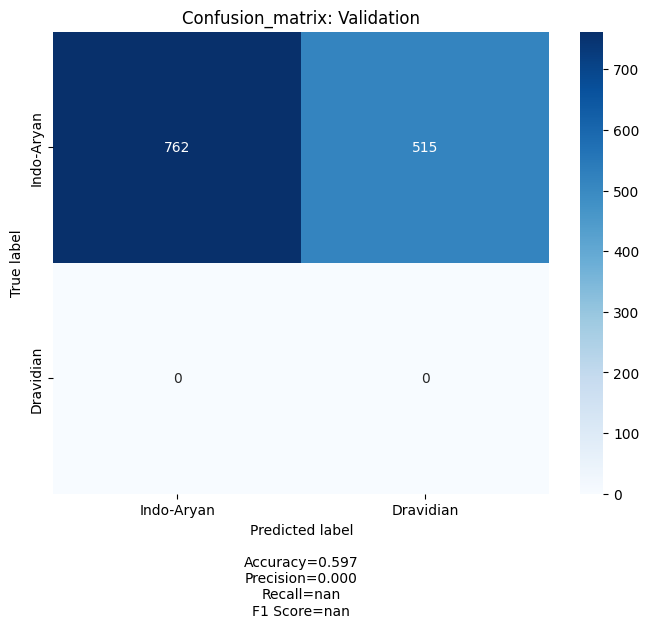

:::::Total validation loss 6.211923408508301, Training accuracy 100.0%, Validation accuracy 59.671104150352384% after 22 epochs
Epoch: 23, Batch: 0, Loss: 6.057822247385047e-06, Accuracy: 100.0%
Total training loss 4.5615113474895e-05 and training Accuracy 100.0% after 23 epochs
#####TEST--in-domain:::::Epoch: 23, Batch: 0, Loss: 8.949566841125488, Accuracy:46.875%


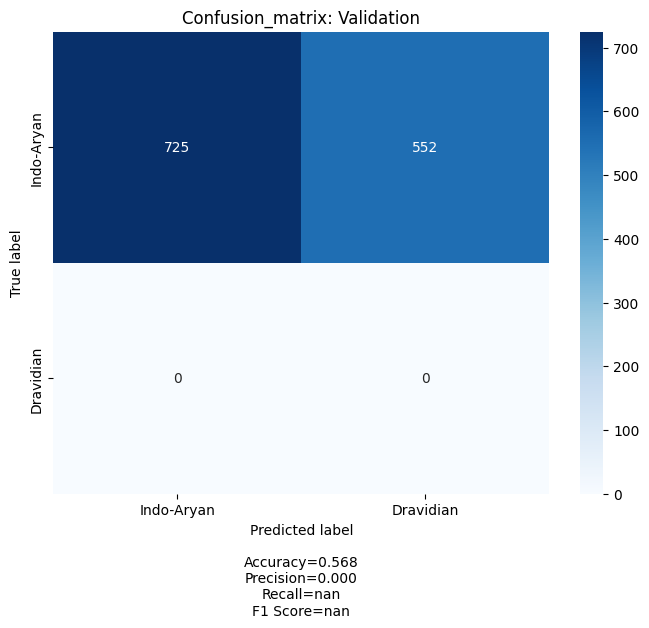

:::::Total validation loss 7.171056461334229, Training accuracy 100.0%, Validation accuracy 56.77368833202819% after 23 epochs
Epoch: 24, Batch: 0, Loss: 8.698493911651894e-05, Accuracy: 100.0%
Total training loss 0.0004386163896015205 and training Accuracy 100.0% after 24 epochs
#####TEST--in-domain:::::Epoch: 24, Batch: 0, Loss: 4.705202579498291, Accuracy:65.625%


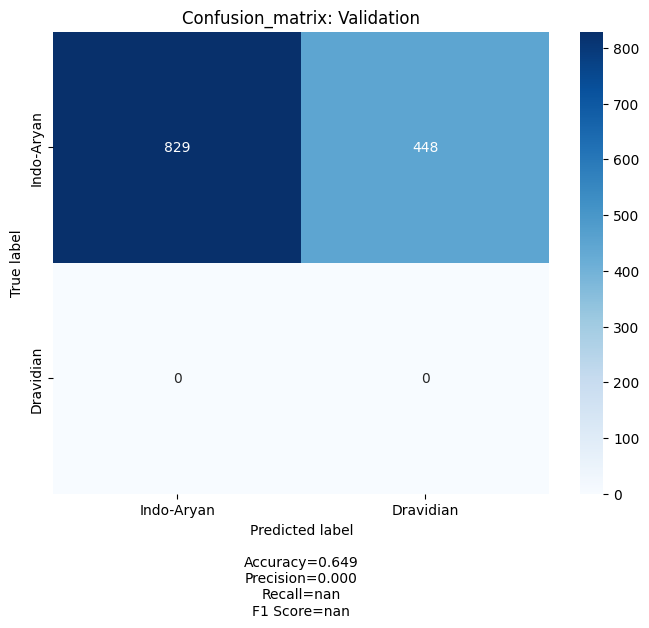

:::::Total validation loss 5.132891261577607, Training accuracy 100.0%, Validation accuracy 64.9177760375881% after 24 epochs
Epoch: 25, Batch: 0, Loss: 4.516037733992562e-05, Accuracy: 100.0%
Total training loss 8.24762799573886e-05 and training Accuracy 100.0% after 25 epochs
#####TEST--in-domain:::::Epoch: 25, Batch: 0, Loss: 6.108344554901123, Accuracy:60.9375%


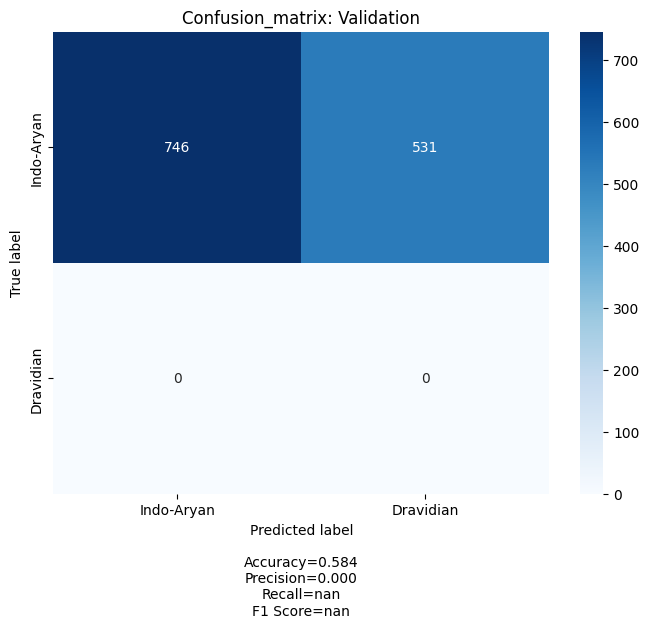

:::::Total validation loss 6.687656962871552, Training accuracy 100.0%, Validation accuracy 58.41816758026624% after 25 epochs
Epoch: 26, Batch: 0, Loss: 6.224341632332653e-05, Accuracy: 100.0%
Total training loss 0.0001139147830073739 and training Accuracy 100.0% after 26 epochs
#####TEST--in-domain:::::Epoch: 26, Batch: 0, Loss: 6.839015960693359, Accuracy:62.5%


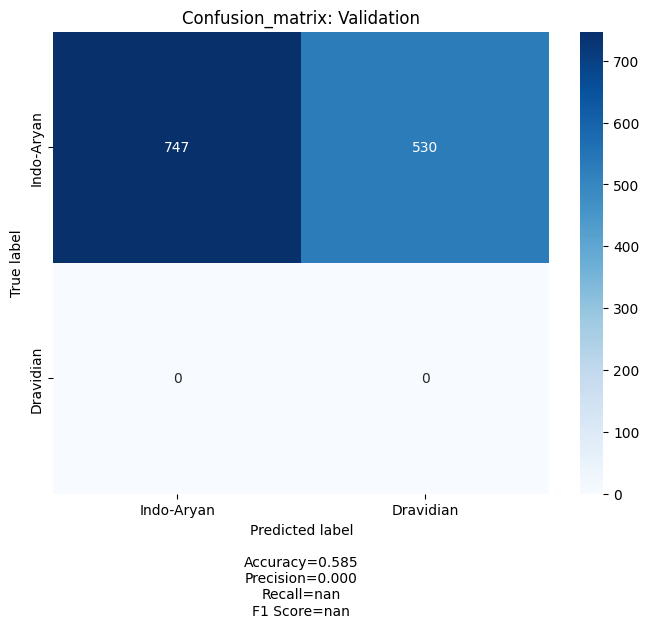

:::::Total validation loss 6.83237476348877, Training accuracy 100.0%, Validation accuracy 58.496476115896634% after 26 epochs
Epoch: 27, Batch: 0, Loss: 1.598375638423022e-05, Accuracy: 100.0%
Total training loss 0.0001617779587022028 and training Accuracy 100.0% after 27 epochs
#####TEST--in-domain:::::Epoch: 27, Batch: 0, Loss: 6.9900803565979, Accuracy:56.25%


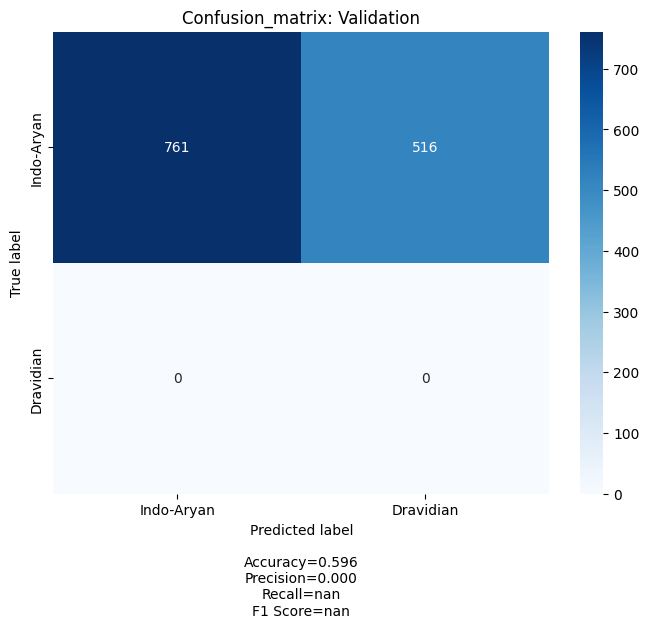

:::::Total validation loss 6.388135051727295, Training accuracy 100.0%, Validation accuracy 59.59279561472201% after 27 epochs
Epoch: 28, Batch: 0, Loss: 2.0831448637181893e-05, Accuracy: 100.0%
Total training loss 7.397146589482873e-05 and training Accuracy 100.0% after 28 epochs
#####TEST--in-domain:::::Epoch: 28, Batch: 0, Loss: 4.791887283325195, Accuracy:68.75%


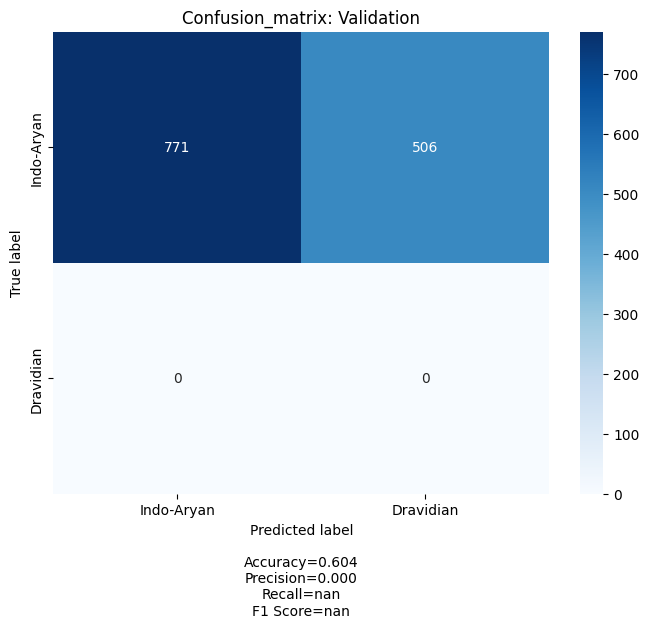

:::::Total validation loss 6.20465829372406, Training accuracy 100.0%, Validation accuracy 60.37588097102584% after 28 epochs
Epoch: 29, Batch: 0, Loss: 8.521355084667448e-06, Accuracy: 100.0%
Total training loss 5.316267241894934e-05 and training Accuracy 100.0% after 29 epochs
#####TEST--in-domain:::::Epoch: 29, Batch: 0, Loss: 6.105869293212891, Accuracy:67.1875%


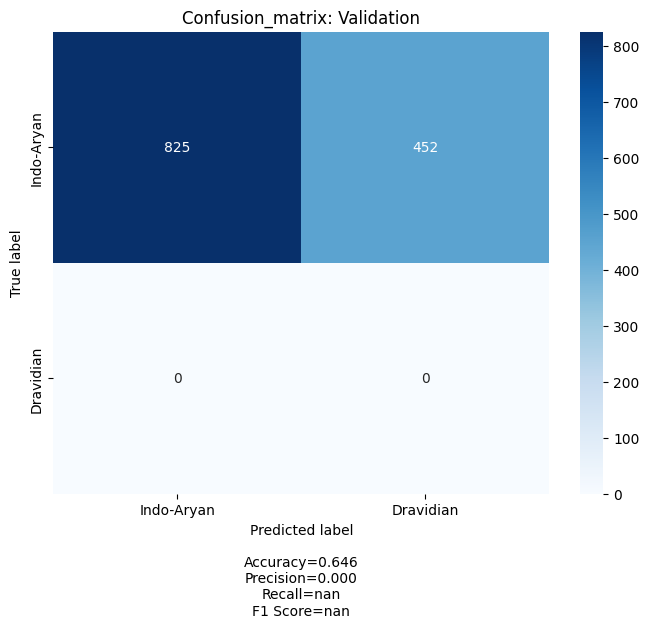

:::::Total validation loss 5.367692255973816, Training accuracy 100.0%, Validation accuracy 64.60454189506656% after 29 epochs
Epoch: 30, Batch: 0, Loss: 1.607640297152102e-05, Accuracy: 100.0%
Total training loss 5.171200076503624e-05 and training Accuracy 100.0% after 30 epochs
#####TEST--in-domain:::::Epoch: 30, Batch: 0, Loss: 6.719173908233643, Accuracy:57.8125%


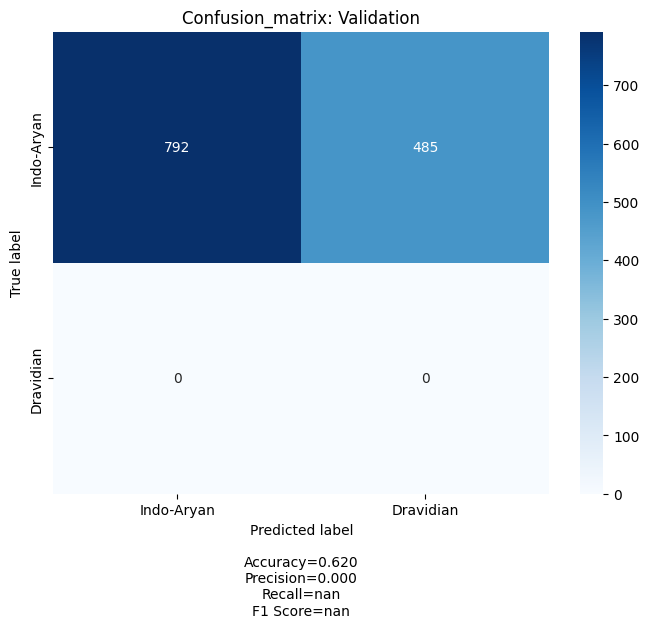

:::::Total validation loss 5.629775583744049, Training accuracy 100.0%, Validation accuracy 62.02036021926391% after 30 epochs
Epoch: 31, Batch: 0, Loss: 2.8761733119608834e-05, Accuracy: 100.0%


KeyboardInterrupt: 

In [38]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
import cf_matrix

def train(dataloader_train, epoch):
    train_loss_list = []
    train_acc_list = []
    full_preds = []
    full_gts = []

    model.train()
    for i_batch, data in enumerate(dataloader_train, 0):
        features, labels = data
        features, labels = features.to(device).float(), labels.to(device).long()
        features.requires_grad = True
        optimizer.zero_grad()
        pred_logits = model(features)
        loss = model.get_loss(pred_logits, labels)
        posterior = model.get_posterior()

        loss.backward()
        optimizer.step()
        predictions = np.argmax(posterior.detach().cpu().numpy(), axis=1)
        if i_batch % 50 == 0:
            acc = accuracy_score(predictions, labels.cpu())
            print(f"Epoch: {epoch}, Batch: {i_batch}, Loss: {loss}, Accuracy: {acc*100}%")
        train_loss_list.append(loss.item())
        full_preds.extend(predictions)
        full_gts.extend(labels.detach().cpu().numpy())

    mean_acc = accuracy_score(full_gts, full_preds)
    mean_loss = np.mean(np.asarray(train_loss_list))
    print(f'Total training loss {mean_loss} and training Accuracy {mean_acc*100}% after {epoch} epochs')
    return mean_acc

def validation(dataloader_val, epoch, train_accuracy):
    model.eval()
    with torch.no_grad():
        val_loss_list = []
        full_preds = []
        full_gts = []
        for i_batch, data in enumerate(dataloader_val, 0):
            features, labels = data
            features, labels = features.to(device).float(), labels.to(device).long()
            pred_logits = model(features)
            loss = model.get_loss(pred_logits, labels)
            posterior = model.get_posterior()
            val_loss_list.append(loss.item())
            predictions = np.argmax(posterior.detach().cpu().numpy(), axis=1)
            if i_batch % 50 == 0:
                acc = accuracy_score(predictions, labels.cpu())
                print(f"#####TEST--in-domain:::::Epoch: {epoch}, Batch: {i_batch}, Loss: {loss}, Accuracy:{acc*100}%")
            full_preds.extend(predictions)
            full_gts.extend(labels.detach().cpu().numpy())

        mean_acc2 = accuracy_score(full_gts, full_preds)
        mean_loss2 = np.mean(np.asarray(val_loss_list))
        cm = confusion_matrix(full_gts, full_preds)
        cf_matrix.make_confusion_matrix(cm, percent=False, figsize=(8, 6), categories=["Indo-Aryan", "Dravidian"], cbar=True, title="Confusion_matrix: Validation")
        plt.show()
        print(f':::::Total validation loss {mean_loss2}, Training accuracy {train_accuracy*100}%, Validation accuracy {mean_acc2*100}% after {epoch} epochs')
        model_save_path = os.path.join(dest_path, f'No_Punjabi_North_south_binary_Bhagya_ecapa_cms_{train_accuracy*100:.3f}_{mean_acc2*100:.3f}_{mean_loss2:.4f}')
        state_dict = {'model': model.state_dict(), 'optimizer': optimizer.state_dict(), 'epoch': epoch}
        torch.save(state_dict, model_save_path)
        return loss

if __name__ == '__main__':
    for epoch in range (50):
        mean_acc = train(trainloader, epoch)
        val_loss = validation(testloader1, epoch, mean_acc)
        scheduler.step(val_loss)